In [41]:
import codecs
import glob
import os
import re
import time
try:
    import cPickle as pickle
except:
    import pickle

import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import altair as alt

In [42]:


def genModelPreds_biasOC_2LR(outcomes,lr_pos,lr_neg,p0):
    outcomes=np.array(outcomes)

    lrsDf = np.zeros(outcomes.shape)
    lrsDf[outcomes==0]=lr_neg
    lrsDf[outcomes==1]=lr_pos
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lrsDf[:,ii] * (outcomes[:,ii] - pred[:,ii])
    return pred 


def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    return actProbArr

def genChoices(actProbArr):
    probs = np.stack([a.to_numpy() for a in actProbArr], axis=0)  # (K, N, T)
    cum = np.cumsum(probs, axis=0)                                 # (K, N, T)
    u = np.random.random_sample(probs.shape[1:])                   # (N, T)
    # first k where u <= cum[k]
    choices = (u[None, :, :] <= cum).argmax(axis=0) + 1
    return choices



def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll

def optimize2LR_sft_fixedSM_p0(params, choices, outcomes, smax=1):
    lr_pos, lr_neg, p0=params
    lr_pos=np.exp(lr_pos)/(np.exp(lr_pos)+1)
    lr_neg=np.exp(lr_neg)/(np.exp(lr_neg)+1)
    p0=(np.exp(p0)/(np.exp(p0)+1))
    if lr_pos<0 or lr_neg<0 or smax<0 or lr_pos>1 or lr_neg>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR(outcomes,lr_pos, lr_neg,p0)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


In [43]:
def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return np.random.beta(alpha, beta,N)

In [60]:
params_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\data\2LRPosNegOCp0NonSocial_LOT.csv")

params_df = params_df[['PROLIFIC_PID', 'subj2LR_posOC',	'subj2LR_negOC','subj2p0_3prm'
]]
params_df = params_df.rename(columns={
    'subj2LR_posOC': 'lrP',
    'subj2LR_negOC': 'lrN',
    'subj2p0_3prm': 'p0'
})
params_df['smax'] = 1
params_df = params_df.rename(columns={'PROLIFIC_PID': 'PID'})
subjParams = params_df.copy()

In [61]:
subjParams = subjParams.set_index('PID')
datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)
good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in subjParams.index]

subjParams = subjParams.loc[valid_candidates]
subjParams

,lrP,lrN,p0,smax
PID,,,,
61492ac26b91b5b11ba2c88b,0.211092,0.080645,0.279650,1
60234c1d5a0cf81cba76ce5d,0.002099,0.008925,0.455823,1
6362aca86b740b1ec4cb6efb,0.000045,0.128224,0.354730,1
60fcd2b146529d02f1566012,0.035324,0.126447,0.267808,1
63ed12d2c25b08ba24fe8a41,0.375318,0.367642,0.527427,1
...,...,...,...,...
641359eb0e2dc93999637e35,0.074770,0.000045,0.537220,1
63d2bc12a843f8466a8f83e0,0.578121,0.999955,0.454197,1
610b416fd4f5d1dcfaa28d7a,0.509922,0.629920,0.244977,1


In [62]:

print("Parameter means and standard deviations in subjParams:")
for param in ['lrP','lrN','p0']:
    print(f"{param}: mean={subjParams[param].mean():.4f}, std={subjParams[param].std(ddof=1):.4f}")


Parameter means and standard deviations in subjParams:
lrP: mean=0.1516, std=0.2300
lrN: mean=0.1307, std=0.1954
p0: mean=0.5426, std=0.2359


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# -----------------------------
# SIM SETTINGS 
# -----------------------------
nPtp = 100
sftMax = 1
lrP_mu = subjParams['lrP'].mean()
lrPSTD = subjParams['lrP'].std(ddof=1)
lrN_mu = subjParams['lrN'].mean()
lrNSTD = subjParams['lrN'].std(ddof=1)
p0_mu = subjParams['p0'].mean()
p0STD = subjParams['p0'].std(ddof=1)




nTrialsPerTarget = 22
targConting = [[.2,.65], [.35,.8], [.65,.2], [.8,.35], [.2,.65], [.35,.8], [.65,.2], [.8,.35]]
switchRange = 5
conseqContingMin = 8
conditions = ['pSoc']

# -----------------------------
# OUTCOMES 
# -----------------------------

ocArr = []
for ppt in np.arange(nPtp):
    for cond in conditions:
        for conting in targConting:
            switchPnt = np.floor(np.random.random_sample()*switchRange).astype(int) + conseqContingMin
            outcomes = np.concatenate((
                (np.random.random_sample(switchPnt) < conting[0]).astype(int),
                (np.random.random_sample(nTrialsPerTarget-switchPnt) < conting[1]).astype(int)
            ))
            
            ocArr.append(['{:04d}'.format(ppt+1), cond, str(conting), switchPnt] + list(outcomes))

ocDf = pd.DataFrame(
    ocArr,
    columns=['PID', 'cond', 'conting', 'switchPnt'] + [f'oc_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
) 

# =========================================================
# NO-COVARIATE PARAMETER SIMULATION (this is the key change)
# =========================================================

# 1) sample lrs directly (bounded 0..1 via Beta parameterization around lr_mu, lrSTD)
#    - simplest: treat mu constant
lrsP = betaMuSd(mu=lrP_mu, sd=lrPSTD, N=nPtp)

# 2) sample offer0 directly (bounded 0..1). use normal then clip (matches your existing style)
offer0s = np.random.normal(loc=p0_mu, scale=p0STD, size=nPtp)
offer0s = np.clip(offer0s, 0, 1)

#3 sample d directly bounded 0..1 via Beta parameterization around d_mu, d_std)
lrsN = betaMuSd(mu=lrN_mu, sd=lrNSTD, N=nPtp)


print('Offer0s Mu: {:0.4f}'.format(np.mean(offer0s)))
print('Offer0s Std: {:0.4f}'.format(np.std(offer0s, ddof=1)))
print('lrsP Mu: {:0.4f}'.format(np.mean(lrsP)))
print('lrsP Std: {:0.4f}'.format(np.std(lrsP, ddof=1)))
print('lrsN Mu: {:0.4f}'.format(np.mean(lrsN)))
print('lrsN Std: {:0.4f}'.format(np.std(lrsN, ddof=1)))
# subjParams now  has PID/lr/offer0/d
subjParams = pd.DataFrame({
    'PID': ocDf.PID.unique(),
    'lrP': lrsP,
    'lrN' : lrsN,
    'p0': offer0s
})

# -----------------------------
# PREDICTIONS + CHOICES (unchanged)
# -----------------------------
cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'pred_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
predDf = pd.DataFrame(columns=cols)

for ptp,  lrP, lrN, off0 in zip(subjParams.PID,  subjParams.lrP, subjParams.lrN, subjParams.p0):
    outcome_cols = [col for col in ocDf.columns if col.startswith('oc_')]
    ocs = ocDf[ocDf.PID == ptp][outcome_cols]
    if ocs.shape[1] == 0 or ocs.shape[0] == 0:
        print(f"Warning: No outcome columns for PID {ptp}")
        continue
    T = ocs.shape[1]
    initPred = np.full((ocs.shape[0],), off0)
    preds = genModelPreds_biasOC_2LR(ocs, lrP, lrN, initPred)
    preds = np.concatenate((np.array(ocDf.loc[(ocDf.PID==ptp), :'switchPnt']), preds), axis=1)
    predDf = pd.concat([predDf, pd.DataFrame(preds, columns=cols)], ignore_index=True)

actProbs = calcActProbsPosNegOC(predDf.loc[:, predDf.columns.str.startswith('pred')], sftMax)
simChoices = genChoices(actProbs)

cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'ch_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
simChDf = pd.DataFrame(
    np.concatenate((np.array(predDf.loc[:, :'switchPnt']), simChoices), axis=1),
    columns=cols
)
simChDf

subjParams

Offer0s Mu: 0.4877
Offer0s Std: 0.1749
lrsP Mu: 0.2465
lrsP Std: 0.2087
lrsN Mu: 0.2443
lrsN Std: 0.1936


,PID,lrP,lrN,p0
0,0001,0.590041,0.108352,0.328031
1,0002,0.064192,0.444093,0.121093
2,0003,0.023807,0.064335,0.293847
3,0004,0.225620,0.095521,0.591041
4,0005,0.021588,0.351755,0.594029
...,...,...,...,...
95,0096,0.273879,0.638061,0.557712
96,0097,0.159464,0.026722,0.716652
97,0098,0.102577,0.352770,0.211836
98,0099,0.164253,0.547277,0.355991


In [48]:
initCh=simChDf.groupby('PID').mean()['ch_01']
initP=predDf.groupby('PID').mean()['pred_01']

c:\Users\mnand\miniconda3\envs\jpy39\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
""" lrRange=[-2,-0.5,0.5,2,]
p0Range=[-2,-0.5,0.5,2,]
dRange = [-2,-0.5,0.5,2,]
a1,a2,a3 =np.meshgrid(lrRange,p0Range, dRange)
a1=a1.reshape(16,)
a2=a2.reshape(16,)
a3=a3.reshape(16,) """
a1=[0]
a2=[0]

timer=time.time()
for lrs, p0Val in zip(a1, a2):
    fitsDF=pd.DataFrame(columns=['lrP', 'lrN', 'p0','nll'], index=subjParams.PID)
    nll=10000;
    for PID in subjParams.PID:
        result=sp.optimize.minimize(optimize2LR_sft_fixedSM_p0, (lrs,lrs, p0Val),(simChDf.loc[(simChDf.PID==PID),'ch_01':], ocDf.loc[(ocDf.PID==PID), 'oc_01':],sftMax),bounds=((-10,10),(-10,10),(-10,10)))
        fitsDF.loc[PID,'lrP']=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        fitsDF.loc[PID,'lrN']=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        fitsDF.loc[PID,'p0']=np.exp(result.x[2])/(np.exp(result.x[2])+1)
        fitsDF.loc[PID,'nll']=result.fun
        
        # if result.fun<nll:
        #     nll=result.fun
        #     bestLR=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        #     bestP0=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        #     bestNLL=nll

print('finished at: {:02f}'.format(time.time()-timer))
    

finished at: 90.794246


In [50]:
r,p=stats.pearsonr(fitsDF['p0'],subjParams['p0'])
print('fitXog p0: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['lrN'],subjParams['lrN'])
print('fitXog lrN: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['lrP'],subjParams['lrP'])
print('fitXog lrP: r={:.02f}, p={:.03f}'.format(r,p))

fitXog p0: r=0.69, p=0.000
fitXog lrN: r=0.73, p=0.000
fitXog lrP: r=0.76, p=0.000


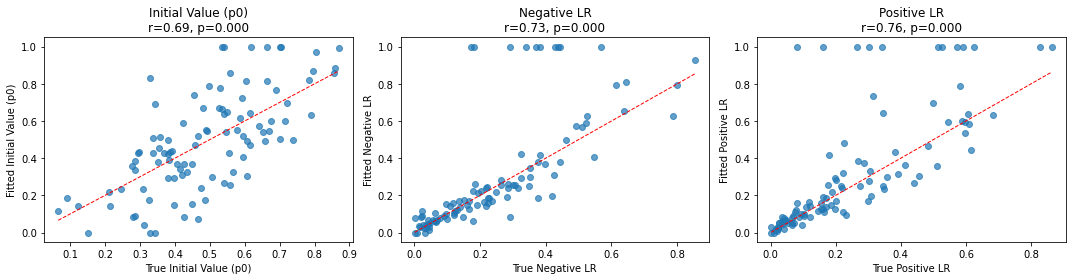

In [51]:
import matplotlib.pyplot as plt

params = ['p0', 'lrN', 'lrP']
titles = {'p0': 'Initial Value (p0)', 'lrN': 'Negative LR', 'lrP': 'Positive LR'}

plt.figure(figsize=(15, 4))
for i, param in enumerate(params):
    plt.subplot(1, 3, i+1)
    plt.scatter(subjParams[param], fitsDF[param], alpha=0.7)
    plt.xlabel(f"True {titles[param]}")
    plt.ylabel(f"Fitted {titles[param]}")
    r, p = stats.pearsonr(fitsDF[param], subjParams[param])
    plt.title(f"{titles[param]}\nr={r:.2f}, p={p:.3f}")
    plt.plot([subjParams[param].min(), subjParams[param].max()],
             [subjParams[param].min(), subjParams[param].max()], 'r--', lw=1)

plt.tight_layout()
plt.show()

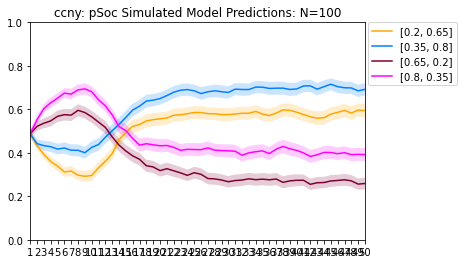

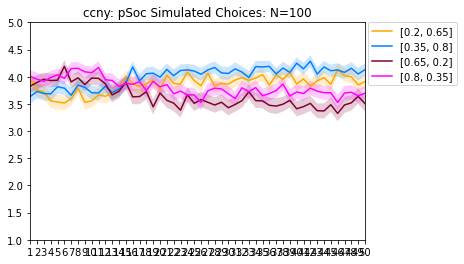

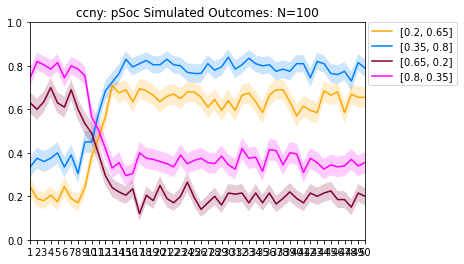

In [52]:
# plt.plot(simChDf.groupby('conting').mean().iloc[0,2:].transpose())

muCrvs=predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs=(predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_ch=simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_ch=(simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_oc=ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_oc=(ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()

colors=np.array([[1,.65,0], [0,.5,1], [.5,0,.2], [1,0,1]])
ind=0;
for conting in muCrvs.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu=np.squeeze(muCrvs.loc[(muCrvs.conting==conting), 'pred_01':].transpose())
    ste=np.squeeze(steCrvs.loc[(steCrvs.conting==conting), 'pred_01':].transpose())

    plt.plot(np.arange(1,mu.shape[0]+1),mu, c=col,label=conting)
    plt.fill_between(np.arange(1,mu.shape[0]+1),mu-ste,mu+ste, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Model Predictions: N={:d}'.format(cond,nPtp))
plt.legend(loc=(1.01,.71))
plt.ylim([0,1])
plt.xlim([1,mu.shape[0]])
plt.xticks(np.arange(1,mu.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

ind=0
for conting in muCrvs_ch.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_ch=np.squeeze(muCrvs_ch.loc[(muCrvs_ch.conting==conting), 'ch_01':].transpose())
    ste_ch=np.squeeze(steCrvs_ch.loc[(steCrvs_ch.conting==conting), 'ch_01':].transpose())

    plt.plot(np.arange(1,mu_ch.shape[0]+1),mu_ch, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_ch.shape[0]+1),mu_ch-ste_ch,mu_ch+ste_ch, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Choices: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([1,5])
plt.xlim([1,mu_ch.shape[0]])
plt.xticks(np.arange(1,mu_ch.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('simCh_n{}_Grant.png'.format(nPtp))
plt.show()

ind=0
for conting in muCrvs_oc.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_oc=np.squeeze(muCrvs_oc.loc[(muCrvs_oc.conting==conting), 'oc_01':].transpose())
    ste_oc=np.squeeze(steCrvs_oc.loc[(steCrvs_oc.conting==conting), 'oc_01':].transpose())

    plt.plot(np.arange(1,mu_oc.shape[0]+1),mu_oc, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_oc.shape[0]+1),mu_oc-ste_oc,mu_oc+ste_oc, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Outcomes: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([0,1])
plt.xlim([1,mu_oc.shape[0]])
plt.xticks(np.arange(1,mu_oc.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

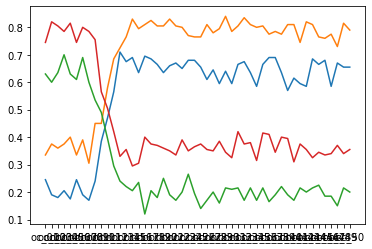

In [53]:
plt.plot(ocDf.groupby('conting').mean().loc[:,'oc_01':].transpose())
plt.show